# Analysis of compression experiments

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass
from einops import einsum
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# Bilinear layer similar to the other notebook (left/right via chunk)
class Bilinear(nn.Linear):
    def __init__(self, d_in: int, d_out: int, bias=False) -> None:
        super().__init__(d_in, 2 * d_out, bias=bias)
    def forward(self, x):
        left, right = super().forward(x).chunk(2, dim=-1)
        return left * right
    @property
    def w_l(self):
        return self.weight.chunk(2, dim=0)[0]
    @property
    def w_r(self):
        return self.weight.chunk(2, dim=0)[1]

@dataclass
class ModelConfig:
    p: int = 64
    d_hidden: int | None = None
    bias: bool = False

class Model(nn.Module):
    def __init__(self, cfg: ModelConfig):
        super().__init__()
        self.bi_linear = Bilinear(d_in=2*cfg.p, d_out=cfg.d_hidden, bias=cfg.bias)
        self.projection = nn.Linear(cfg.d_hidden, cfg.p, bias=cfg.bias)
    def forward(self, x):
        return self.projection(self.bi_linear(x))
    @property
    def w_l(self):
        return self.bi_linear.w_l
    @property
    def w_r(self):
        return self.bi_linear.w_r
    @property
    def w_p(self):
        return self.projection.weight

def init_model(p, d_hidden):
    cfg = ModelConfig(p=p, d_hidden=d_hidden, bias=False)
    return Model(cfg)


Device: cuda


## Loading trained models and final validation accuracies

In [2]:
import time
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load sweep results here by choosing the file below. 
# Note that I changed the keys of the saved dict. I always saved the model_state_dicts and the final validation accuracies, which is all that is really needed.  
file_path = 'comp_diagrams/sweep_results_0401.pkl' # change as needed
with open(f'{file_path}', 'rb') as f:
    data = pickle.load(f)
models_state = data.get('models', data.get('models_state', {}))
val_acc = data.get("val_accs", {})

if file_path == 'sweep_results_0401.pkl':
    P = 64
else: 
    P = data.get("P", 64)

## Validation curve

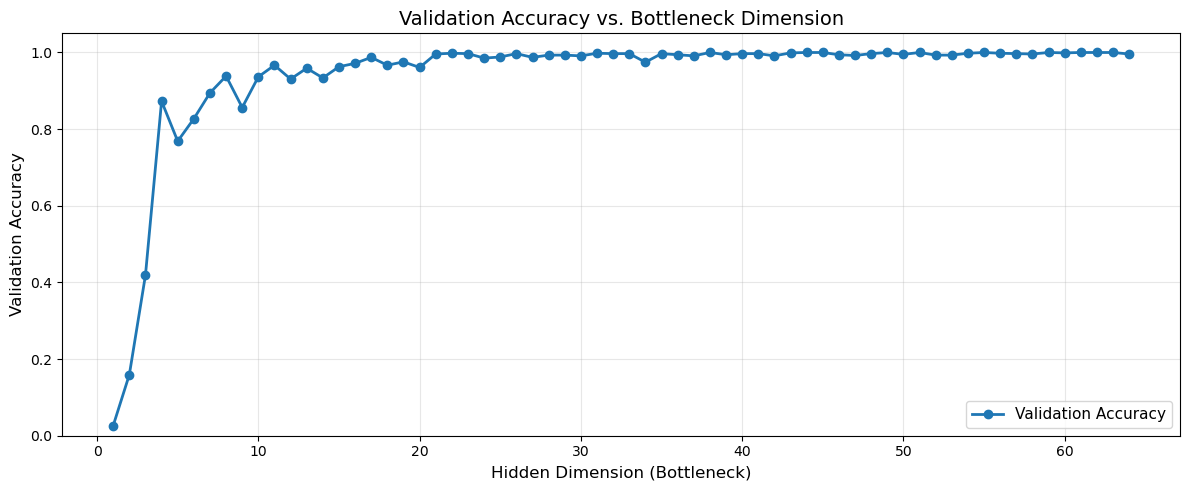

IntSlider(value=0, description='Dim Index', max=63, step=-1)

Output()

In [3]:
# Visualize validation accuracies across bottleneck dimensions
if len(val_acc) == 0:
    print('No validation accuracies available. Run the sweep cell first.')
else:
    dims_sorted = sorted(list(val_acc.keys()), reverse=True)  # P down to 1
    accs_sorted = [val_acc[d] for d in dims_sorted]
    
    # Plot all accuracies
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(dims_sorted, accs_sorted, 'o-', linewidth=2, markersize=6, label='Validation Accuracy')
    ax.set_xlabel('Hidden Dimension (Bottleneck)', fontsize=12)
    ax.set_ylabel('Validation Accuracy', fontsize=12)
    ax.set_title('Validation Accuracy vs. Bottleneck Dimension', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)
    ax.set_ylim([0, 1.05])
    plt.tight_layout()
    plt.show()
    
    # Interactive slider to inspect individual dim
    def show_acc(dim_idx=0):
        d = dims_sorted[dim_idx]
        acc = val_acc[d]
        print(f'd_hidden = {d:2d}  →  Validation Accuracy = {acc:.4f}')
    
    dim_slider = widgets.IntSlider(min=0, max=len(dims_sorted)-1, step=-1, description='Dim Index')
    out = widgets.interactive_output(show_acc, {'dim_idx': dim_slider})
    display(dim_slider, out)

Looking at the validation accuracy curve, it is clear that a lot of compression is possible. The smallest bottleneck dimension with perfect generalisation `val_acc = 1.0` was 38. Looking the curve, it is clear however, that the model performs well at least down to bottleneck dim 20. There is a steep decline in performance starting around bottleneck dimension 10.    

## Interaction matrices

In [4]:
# Compute full interaction matrices:
int_mats = {}
for d_hidden, model_state in models_state.items():
    model = init_model(p=P, d_hidden=d_hidden).to(device)
    model.load_state_dict(model_state)
    w_l = model.w_l.detach()  # (d_hidden, 2*P) -> (d_hidden, P)
    w_r = model.w_r.detach()  # (d_hidden, 2*P) -> (d_hidden, P)
    w_p = model.w_p.detach()  # (P, d_hidden)
    
    # Compute interaction matrices
    b = einsum(w_l, w_r, w_p, "hid in1, hid in2, p hid -> p in1 in2").cpu().detach().numpy()  # (P, P), CP decomposition
    int_mats[d_hidden] = 0.5 * (b + b.transpose(0, 2, 1)) # symmetric part only

In [5]:

# Interactive exploration of computed interaction matrices
def show_mat(size: int = P, remainder: int = 0):
    mat = int_mats[size][remainder]
    plt.figure(figsize=(6,5))
    im = plt.imshow(mat, cmap='RdBu', aspect='auto', origin="lower")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(f'd_hidden={size}, remainder={remainder}')
    plt.show()
size_slider = widgets.IntSlider(min=1, max=P, step=1, description='dim idx')
rem_slider = widgets.IntSlider(min=0, max=P-1, step=1, description='rem idx')
out = widgets.interactive_output(show_mat, {'size': size_slider, 'remainder': rem_slider})
display(widgets.HBox([size_slider, rem_slider]), out)

Output()

Similar to application case. More compressed cases have more negative weights indicating maybe error correction and deconstructive interference? Also, here seem be to be lines seperating the matrices in four equal sized blocks which makes kind of sense given that there should be a symmetry there aswell: $(a + b) \textrm{mod} P=(b + a) \textrm{mod} P$ Another strange thing is the appearance of a diagonal. Maybe this is due $P$ not being chosen a prime number here? Probably not. 

## Looking at latent space
Instead at looking at the full bilinear layer, can we learn about how the model is mapping its input into the bottleneck?
Each bilinear layer has its state saved as `model_state.keys()=['bi_linear.weight', 'projection.weight']`.

In [6]:
def lr_interaction_matrices(model: Model) -> torch.FloatTensor:
    b = einsum(model.w_l, model.w_r, "hid i, hid j -> hid i j")
    return 0.5 * (b + b.transpose(-1, -2)) # why is this not symmetric?

init_mats = {}
unembedding = {}
for bottleck_dim in range(1, P+1):
    model = init_model(64, bottleck_dim)
    model.load_state_dict(state_dict=models_state[bottleck_dim])
    init_mats[bottleck_dim] = lr_interaction_matrices(model).detach().numpy()
    unembedding[bottleck_dim] = model.w_p.detach().numpy()

# TODO: Check that matrices are symmetric
for bottleneck_size in range(1, P+1):
    mat = init_mats[bottleneck_size]
    if not np.allclose(mat, np.transpose(mat, axes=(0, 2, 1))):
        print(f'Warning: Interaction matrix for bottleneck size {bottleneck_size} is not symmetric!')

In [7]:
# TODO: visualize init_mats with sliders (bottleneck dim and bottleck dim index)
def show_lr_mat(bottleneck_size=0, bottleneck_dim=0):
    mat = init_mats[bottleneck_size][bottleneck_dim]
    plt.figure(figsize=(6,5))
    im = plt.imshow(mat, cmap='RdBu', aspect='auto', origin="lower")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(f'LR Interaction Matrix bottleneck_size={bottleneck_size}, hidden dim={bottleneck_dim+1}')
    plt.show()

size_slider = widgets.IntSlider(min=1, max=P, step=1, description='size')
hid_slider = widgets.IntSlider(min=0, max=P-1, step=1, description='dim')
out = widgets.interactive_output(show_lr_mat, {'bottleneck_size': size_slider, 'bottleneck_dim': hid_slider})
display(widgets.HBox([size_slider, hid_slider]), out)

Output()

Visualisations show that LR encodes frequencies. Weird lines are cleary visible separating the matrices in four equal sized blocks.
Claude said in an earlier session: "The 4-block structure you noted in the interaction matrices (the "weird lines") comes directly from this - the matrix naturally decomposes into (a,a), (a,b), (b,a), (b,b) quadrants, and the (a,b)/(b,a) blocks encode the actual addition while (a,a)/(b,b) should be mostly zero or noise."

In [8]:
# TODO: vizualise unembedding matrices with int text widgets.
def show_unembedding_mat(bottleneck_size=0):
    mat = unembedding[bottleneck_size]
    plt.figure(figsize=(6,5))
    im = plt.imshow(mat, cmap='RdBu', aspect='auto', origin="lower")
    plt.xlabel("latent dim")
    plt.ylabel("remainders")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(f'Unembedding Matrix bottleneck_size={bottleneck_size}')
    plt.show()
dim_slider = widgets.IntSlider(min=1, max=P, step=1, description='size')
out = widgets.interactive_output(show_unembedding_mat, {'bottleneck_size': dim_slider})
display(widgets.HBox([dim_slider]), out)

Output()

## Cosine similarity

In [9]:
def inner_product(model1: Model, model2: Model) -> torch.FloatTensor:
    l_12 = einsum(model1.w_l, model2.w_l, "hid1 i, hid2 i -> hid1 hid2")
    r_12 = einsum(model1.w_r, model2.w_r, "hid1 i, hid2 i -> hid1 hid2")
    lr = l_12 * r_12
    dd = einsum(model1.w_p, model2.w_p, "o hid1, o hid2 -> hid1 hid2")
    hid = einsum(lr, dd, "hid1 hid2, hid1 hid3 -> hid2 hid3")
    return torch.trace(hid)

def symmetric_inner(model1: Model, model2: Model) -> torch.FloatTensor:
    ll = einsum(model1.w_l, model2.w_l, "hid1 i, hid2 i -> hid1 hid2")
    rr = einsum(model1.w_r, model2.w_r, "hid1 i, hid2 i -> hid1 hid2")

    lr = einsum(model1.w_l, model2.w_r, "hid1 i, hid2 i -> hid1 hid2")
    rl = einsum(model1.w_r, model2.w_l, "hid1 i, hid2 i -> hid1 hid2")

    core = 1/2 * ((ll*rr) + (lr*rl))
    
    dd = einsum(model1.w_p, model2.w_p, "o hid1, o hid2 -> hid1 hid2")
    hid = einsum(core, dd, "hid1 hid2, hid1 hid3 -> hid2 hid3")
    return torch.trace(hid)

def tn_similarity(model1: Model, model2: Model) -> torch.FloatTensor:
    if model1 == model2:
        return torch.tensor(1.0)
    inner = inner_product(model1, model2)
    norm1 = torch.sqrt(inner_product(model1, model1))
    norm2 = torch.sqrt(inner_product(model2, model2))
    return inner / (norm1 * norm2)

def symmetric_similarity(model1: Model, model2: Model) -> torch.FloatTensor:
    if model1 == model2:
        return torch.tensor(1.0)
    inner = symmetric_inner(model1, model2)
    norm1 = torch.sqrt(symmetric_inner(model1, model1))
    norm2 = torch.sqrt(symmetric_inner(model2, model2))
    return inner / (norm1 * norm2)

# helper: instantiate and load model for a given dim
def load_model_for_dim(d):
    m = init_model(P, d)
    state = models_state[d]
    m.load_state_dict(state)
    return m

In [10]:
doSymmetric = True
sym_func = symmetric_similarity if doSymmetric else tn_similarity

# Time similarity computation for d=64 vs d=63 if available
if P in models_state and (P-1) in models_state:
    full = load_model_for_dim(P)
    next = load_model_for_dim(P-1)
    torch.set_grad_enabled(False)
    t0 = time.perf_counter()
    tn_similarity = sym_func(full, next)
    t1 = time.perf_counter()
    dt = t1 - t0
    print(f'TN similarity d={P} vs d={P-1}: {tn_similarity:.6f} (computed in {dt:.3f}s)')
else:
    print('Models for d=64 or d=63 not found in saved states; skipping timing check')

# If timing is reasonable, compute full pairwise similarity matrix and plot heatmap
time_threshold = 10.0  # seconds; adjust as needed
if 'dt' in locals() and dt < time_threshold:
    print('Computing full pairwise TN similarity matrix...')
    sim_mat = np.zeros((P, P), dtype=float)
    models_cache = {}
    for i, di in enumerate(range(1, P+1)):
        models_cache[di] = load_model_for_dim(di)
    for i, di in enumerate(range(1, P+1)):
        for j, dj in enumerate(range(1, P+1)):
            if j < i:
                sim_mat[i, j] = sim_mat[j, i] # no need to repeat computations. similarity matrix is symmetric
            else:
                s = float(sym_func(models_cache[di], models_cache[dj]))
                sim_mat[i, j] = s

TN similarity d=64 vs d=63: 0.137113 (computed in 0.005s)
Computing full pairwise TN similarity matrix...


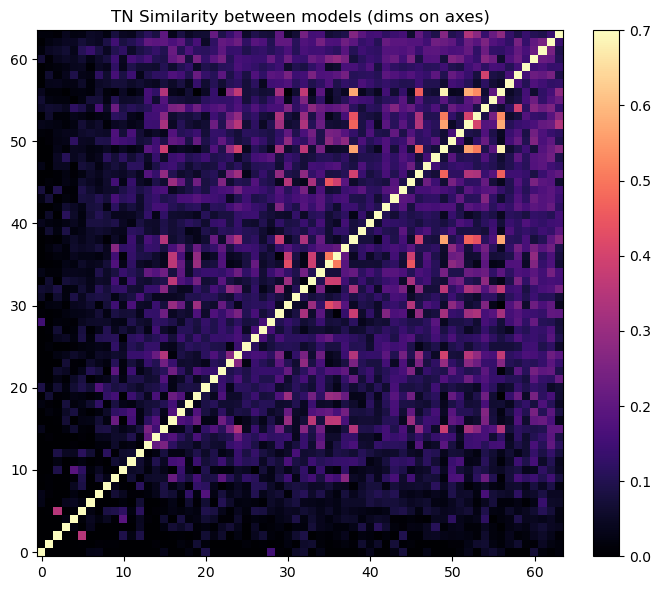

In [11]:
# Plot heatmap
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(sim_mat, cmap='magma', vmin=0, vmax=0.7, origin="lower")
# ax.set_xticks(np.arange(P))
# ax.set_yticks(np.arange(P))
# ax.set_xticklabels(np.arange(P), rotation=90)
# ax.set_yticklabels(np.arange(P))
ax.set_title('TN Similarity between models (dims on axes)')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [12]:
# compute TN sim across training.

## Eigendecomposition

### Analysis Plan
We analyze the interaction matrices (with projection head) using eigendecomposition.

### Effective Rank
Before diving into individual components, we compute effective rank of the interaction matrices:
- **Entropy-based**: `exp(entropy of normalized |λ|²)` - smooth measure of eigenvalue spread
- **Ratio-based**: `sum(|λ|) / max(|λ|)` (nuclear norm / spectral norm)

### Eigenvalues
Eigenvalues are positive and negative, with many near-zero (unimportant) ones. We sort by absolute magnitude and determine importance via:
1. **Cumulative explained variance**: `sum(|λ_kept|²) / sum(|λ_all|²)` - data-independent

We plot important/kept components against bottleneck size to assess compression effects.

### Eigenvectors (FFT Analysis)
Eigenvectors appear to have the form: $v[\mathrm{dim}] \approx \sum_{i} \alpha_i \cos(\omega_i \cdot \mathrm{dim} + \varphi_i)$

We use FFT to extract frequency content:
- For top eigenvectors per remainder, compute FFT and identify dominant frequencies
- Plot frequency content vs bottleneck size
- Create heatmaps (remainder × frequency) for different bottleneck sizes

In [13]:
# Eigendecomposition of interaction matrices
# For each bottleneck size and each remainder, compute eigenvalues and eigenvectors

eigen_data = {}  # eigen_data[d_hidden] = {'eigenvalues': (P, 2P), 'eigenvectors': (P, 2P, 2P)}

for d_hidden in tqdm(range(1, P+1), desc="Computing eigendecomposition"):
    int_mat = int_mats[d_hidden]  # shape: (P, 2P, 2P)
    eigenvalues = []
    eigenvectors = []
    
    for remainder in range(P):
        mat = int_mat[remainder]  # shape: (2P, 2P), symmetric
        evals, evecs = np.linalg.eigh(mat)  # eigh for symmetric matrices
        # Sort by absolute magnitude (descending)
        sort_idx = np.argsort(np.abs(evals))[::-1]
        evals = evals[sort_idx]
        evecs = evecs[:, sort_idx]
        eigenvalues.append(evals)
        eigenvectors.append(evecs)
    
    eigen_data[d_hidden] = {
        'eigenvalues': np.array(eigenvalues),    # (P, 2P)
        'eigenvectors': np.array(eigenvectors)   # (P, 2P, 2P)
    }

print(f"Computed eigendecomposition for {len(eigen_data)} models")

Computing eigendecomposition: 100%|██████████| 64/64 [00:25<00:00,  2.49it/s]

Computed eigendecomposition for 64 models


### Effective Rank

In [14]:
# Effective rank definitions

def entropy_effective_rank(eigenvalues: np.ndarray) -> float:
    """Entropy-based effective rank: exp(entropy of normalized |λ|²)"""
    evals_sq = eigenvalues ** 2
    # Normalize to get probability distribution
    total = evals_sq.sum()
    if total < 1e-12:
        return 0.0
    p = evals_sq / total
    # Filter out zeros to avoid log(0)
    p = p[p > 1e-12]
    entropy = -np.sum(p * np.log(p))
    return np.exp(entropy)

def ratio_effective_rank(eigenvalues: np.ndarray) -> float:
    """Ratio-based effective rank: sum(|λ|) / max(|λ|) (nuclear/spectral norm ratio)"""
    abs_evals = np.abs(eigenvalues)
    max_eval = abs_evals.max()
    if max_eval < 1e-12:
        return 0.0
    return abs_evals.sum() / max_eval

# Compute effective ranks for all models
# We average across remainders for each bottleneck size
entropy_ranks = {}
ratio_ranks = {}

for d_hidden in range(1, P+1):
    evals = eigen_data[d_hidden]['eigenvalues']  # (P, 2P)
    
    entropy_per_remainder = [entropy_effective_rank(evals[r]) for r in range(P)]
    ratio_per_remainder = [ratio_effective_rank(evals[r]) for r in range(P)]
    
    entropy_ranks[d_hidden] = {
        'mean': np.mean(entropy_per_remainder),
        'std': np.std(entropy_per_remainder),
        'per_remainder': entropy_per_remainder
    }
    ratio_ranks[d_hidden] = {
        'mean': np.mean(ratio_per_remainder),
        'std': np.std(ratio_per_remainder),
        'per_remainder': ratio_per_remainder
    }

print("Computed effective ranks for all models")

Computed effective ranks for all models


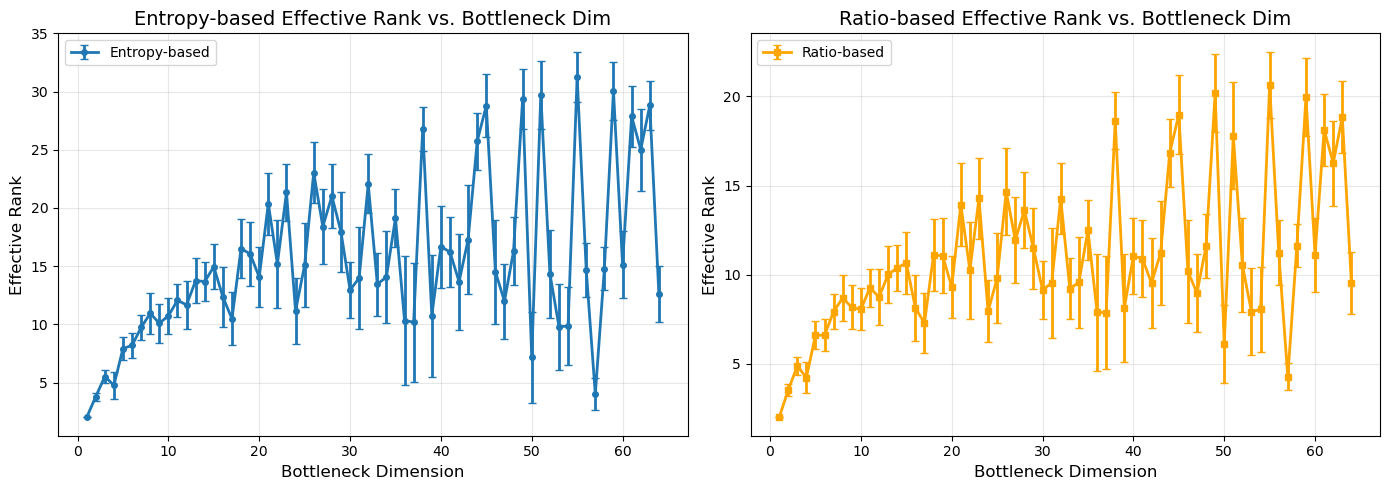

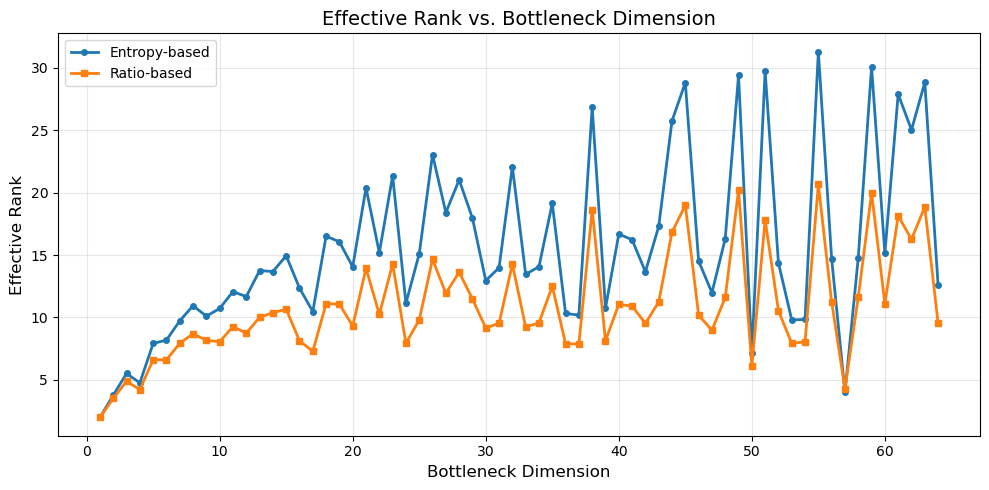

In [15]:
# Plot effective ranks vs bottleneck dimension
dims = list(range(1, P+1))
entropy_means = [entropy_ranks[d]['mean'] for d in dims]
entropy_stds = [entropy_ranks[d]['std'] for d in dims]
ratio_means = [ratio_ranks[d]['mean'] for d in dims]
ratio_stds = [ratio_ranks[d]['std'] for d in dims]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Entropy-based effective rank
ax1 = axes[0]
ax1.errorbar(dims, entropy_means, yerr=entropy_stds, fmt='o-', capsize=3, 
             linewidth=2, markersize=4, label='Entropy-based')
ax1.set_xlabel('Bottleneck Dimension', fontsize=12)
ax1.set_ylabel('Effective Rank', fontsize=12)
ax1.set_title('Entropy-based Effective Rank vs. Bottleneck Dim', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Ratio-based effective rank
ax2 = axes[1]
ax2.errorbar(dims, ratio_means, yerr=ratio_stds, fmt='s-', capsize=3,
             linewidth=2, markersize=4, color='orange', label='Ratio-based')
ax2.set_xlabel('Bottleneck Dimension', fontsize=12)
ax2.set_ylabel('Effective Rank', fontsize=12)
ax2.set_title('Ratio-based Effective Rank vs. Bottleneck Dim', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Also plot both on same axes for comparison
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dims, entropy_means, 'o-', linewidth=2, markersize=4, label='Entropy-based')
ax.plot(dims, ratio_means, 's-', linewidth=2, markersize=4, label='Ratio-based')
ax.set_xlabel('Bottleneck Dimension', fontsize=12)
ax.set_ylabel('Effective Rank', fontsize=12)
ax.set_title('Effective Rank vs. Bottleneck Dimension', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

### Cumulative Explained Variance
Determine how many eigencomponents are needed to explain a given fraction of variance.

In [16]:
def cumulative_explained_variance(eigenvalues: np.ndarray) -> np.ndarray:
    """Compute cumulative explained variance for sorted eigenvalues (by abs magnitude)."""
    evals_sq = eigenvalues ** 2
    total = evals_sq.sum()
    if total < 1e-12:
        return np.zeros_like(evals_sq)
    return np.cumsum(evals_sq) / total

def components_for_variance_threshold(eigenvalues: np.ndarray, threshold: float = 0.99) -> int:
    """Return number of components needed to exceed variance threshold."""
    cev = cumulative_explained_variance(eigenvalues)
    idx = np.searchsorted(cev, threshold)
    return min(idx + 1, len(eigenvalues))

# Compute for multiple thresholds
variance_thresholds = [0.90, 0.95, 0.99]
components_needed = {thresh: {} for thresh in variance_thresholds}

for d_hidden in range(1, P+1):
    evals = eigen_data[d_hidden]['eigenvalues']  # (P, 2P), already sorted by |λ|
    
    for thresh in variance_thresholds:
        comps_per_remainder = [components_for_variance_threshold(evals[r], thresh) for r in range(P)]
        components_needed[thresh][d_hidden] = {
            'mean': np.mean(comps_per_remainder),
            'std': np.std(comps_per_remainder),
            'max': np.max(comps_per_remainder),
            'per_remainder': comps_per_remainder
        }

print("Computed components needed for variance thresholds:", variance_thresholds)

Computed components needed for variance thresholds: [0.9, 0.95, 0.99]


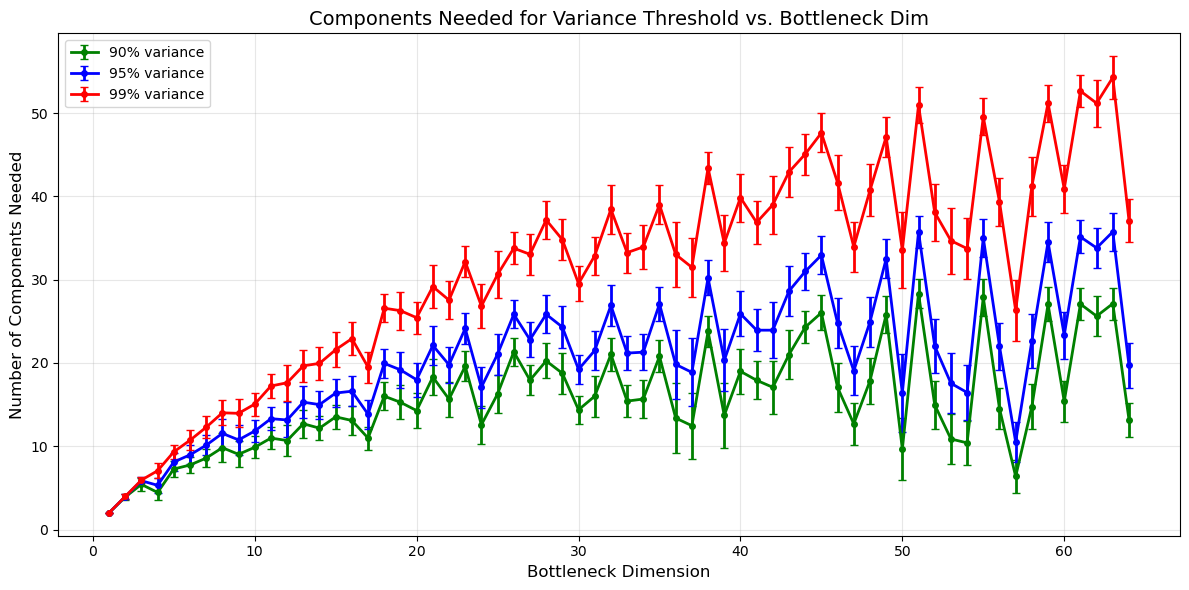

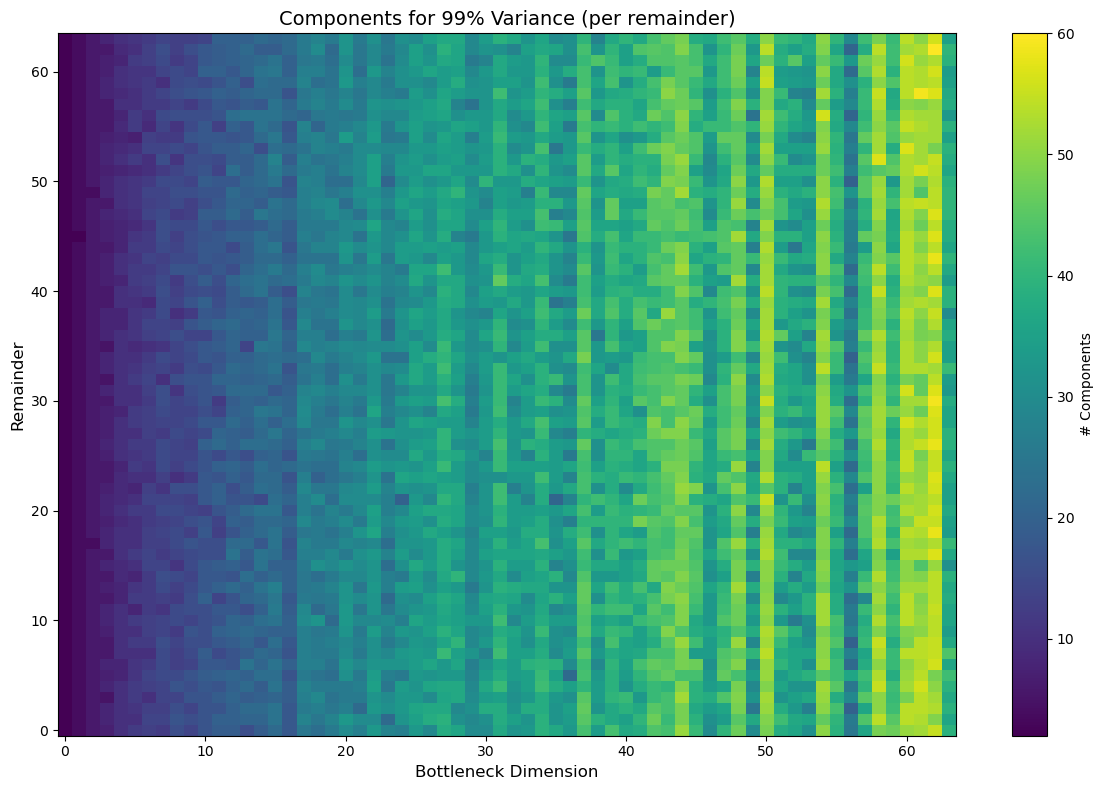

In [17]:
# Plot components needed vs bottleneck dimension for each variance threshold
fig, ax = plt.subplots(figsize=(12, 6))

dims = list(range(1, P+1))
colors = ['green', 'blue', 'red']

for thresh, color in zip(variance_thresholds, colors):
    means = [components_needed[thresh][d]['mean'] for d in dims]
    stds = [components_needed[thresh][d]['std'] for d in dims]
    ax.errorbar(dims, means, yerr=stds, fmt='o-', capsize=3, linewidth=2, 
                markersize=4, color=color, label=f'{int(thresh*100)}% variance')

ax.set_xlabel('Bottleneck Dimension', fontsize=12)
ax.set_ylabel('Number of Components Needed', fontsize=12)
ax.set_title('Components Needed for Variance Threshold vs. Bottleneck Dim', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

# Also show a heatmap: bottleneck dim × remainder for 99% threshold
thresh = 0.99
heatmap_data = np.array([components_needed[thresh][d]['per_remainder'] for d in dims])
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(heatmap_data.T, aspect='auto', cmap='viridis', origin='lower')
ax.set_xlabel('Bottleneck Dimension', fontsize=12)
ax.set_ylabel('Remainder', fontsize=12)
ax.set_title(f'Components for {int(thresh*100)}% Variance (per remainder)', fontsize=14)
plt.colorbar(im, ax=ax, label='# Components')
plt.tight_layout()
plt.show()

### Validation Accuracy Threshold
Reconstruct interaction tensor with top-k eigenvectors and compute accuracy directly.

### FFT Analysis of Eigenvectors
Analyze the frequency content of eigenvectors using FFT.

In [18]:
# FFT analysis of eigenvectors
# Eigenvectors have shape (2P,) where first P elements correspond to input a, last P to input b
# We analyze each half separately and together

def analyze_eigenvector_fft(evec: np.ndarray, p: int) -> dict:
    """
    Compute FFT of an eigenvector and return frequency analysis.
    evec: (2P,) eigenvector
    Returns dict with FFT magnitudes for first half, second half, and combined
    """
    evec_a = evec[:p]  # first input
    evec_b = evec[p:]  # second input
    
    # Compute FFT (real signal, so use rfft)
    fft_a = np.abs(np.fft.rfft(evec_a))
    fft_b = np.abs(np.fft.rfft(evec_b))
    fft_full = np.abs(np.fft.rfft(evec))
    
    return {
        'fft_a': fft_a,
        'fft_b': fft_b,
        'fft_full': fft_full,
        'freqs_a': np.fft.rfftfreq(p, d=1.0),
        'freqs_b': np.fft.rfftfreq(p, d=1.0),
        'freqs_full': np.fft.rfftfreq(2*p, d=1.0)
    }

def dominant_frequencies(fft_magnitudes: np.ndarray, top_k: int = 5) -> np.ndarray:
    """Return indices of top_k dominant frequency components."""
    return np.argsort(fft_magnitudes)[::-1][:top_k]

# Compute FFT for top eigenvectors of each model
n_top_evecs = 4  # analyze top 4 eigenvectors per remainder

fft_data = {}  # fft_data[d_hidden] = list of FFT results

for d_hidden in tqdm(range(1, P+1), desc="Computing FFT analysis"):
    evecs = eigen_data[d_hidden]['eigenvectors']  # (P, 2P, 2P)
    evals = eigen_data[d_hidden]['eigenvalues']   # (P, 2P)
    
    fft_results = []
    for remainder in range(P):
        remainder_ffts = []
        for i in range(min(n_top_evecs, evecs.shape[2])):
            evec = evecs[remainder, :, i]
            fft_result = analyze_eigenvector_fft(evec, P)
            fft_result['eigenvalue'] = evals[remainder, i]
            remainder_ffts.append(fft_result)
        fft_results.append(remainder_ffts)
    
    fft_data[d_hidden] = fft_results

print(f"Computed FFT for top {n_top_evecs} eigenvectors of all models")

Computing FFT analysis:   0%|          | 0/64 [00:00<?, ?it/s]

Computing FFT analysis: 100%|██████████| 64/64 [00:01<00:00, 36.47it/s]

Computed FFT for top 4 eigenvectors of all models


In [19]:
# Visualize eigenvector and its FFT for a specific model
def plot_eigenvector_fft(d_hidden: int, remainder: int, evec_idx: int = 0):
    """Plot eigenvector and its FFT spectrum."""
    evecs = eigen_data[d_hidden]['eigenvectors']
    evals = eigen_data[d_hidden]['eigenvalues']
    
    evec = evecs[remainder, :, evec_idx]
    eval_val = evals[remainder, evec_idx]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot eigenvector (full)
    ax = axes[0, 0]
    ax.plot(evec, 'b-', linewidth=1)
    ax.axvline(P, color='r', linestyle='--', alpha=0.5, label='a|b boundary')
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.set_title(f'Eigenvector (λ={eval_val:.4f})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot eigenvector halves separately
    ax = axes[0, 1]
    ax.plot(evec[:P], 'b-', linewidth=1, label='Input a')
    ax.plot(evec[P:], 'r-', linewidth=1, label='Input b')
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.set_title('Eigenvector (split by input)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # FFT of first half (input a)
    ax = axes[1, 0]
    fft_a = np.abs(np.fft.rfft(evec[:P]))
    freqs_a = np.fft.rfftfreq(P, d=1.0) * P  # Convert to integer frequencies
    ax.stem(freqs_a, fft_a, basefmt=' ')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Magnitude')
    ax.set_title('FFT of Input a component')
    ax.grid(True, alpha=0.3)
    
    # FFT of second half (input b)
    ax = axes[1, 1]
    fft_b = np.abs(np.fft.rfft(evec[P:]))
    freqs_b = np.fft.rfftfreq(P, d=1.0) * P
    ax.stem(freqs_b, fft_b, basefmt=' ')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Magnitude')
    ax.set_title('FFT of Input b component')
    ax.grid(True, alpha=0.3)
    
    fig.suptitle(f'd_hidden={d_hidden}, remainder={remainder}, eigenvector #{evec_idx+1}', fontsize=14)
    plt.tight_layout()
    plt.show()

# Interactive widget for exploring eigenvectors
def interactive_evec_plot(d_hidden=P, remainder=0, evec_idx=0):
    plot_eigenvector_fft(d_hidden, remainder, evec_idx)

d_slider = widgets.IntSlider(min=1, max=P, step=1, value=P, description='d_hidden')
r_slider = widgets.IntSlider(min=0, max=P-1, step=1, value=0, description='remainder')
e_slider = widgets.IntSlider(min=0, max=n_top_evecs-1, step=1, value=0, description='evec_idx')
out = widgets.interactive_output(interactive_evec_plot, {'d_hidden': d_slider, 'remainder': r_slider, 'evec_idx': e_slider})
display(widgets.HBox([d_slider, r_slider, e_slider]), out)

Output()

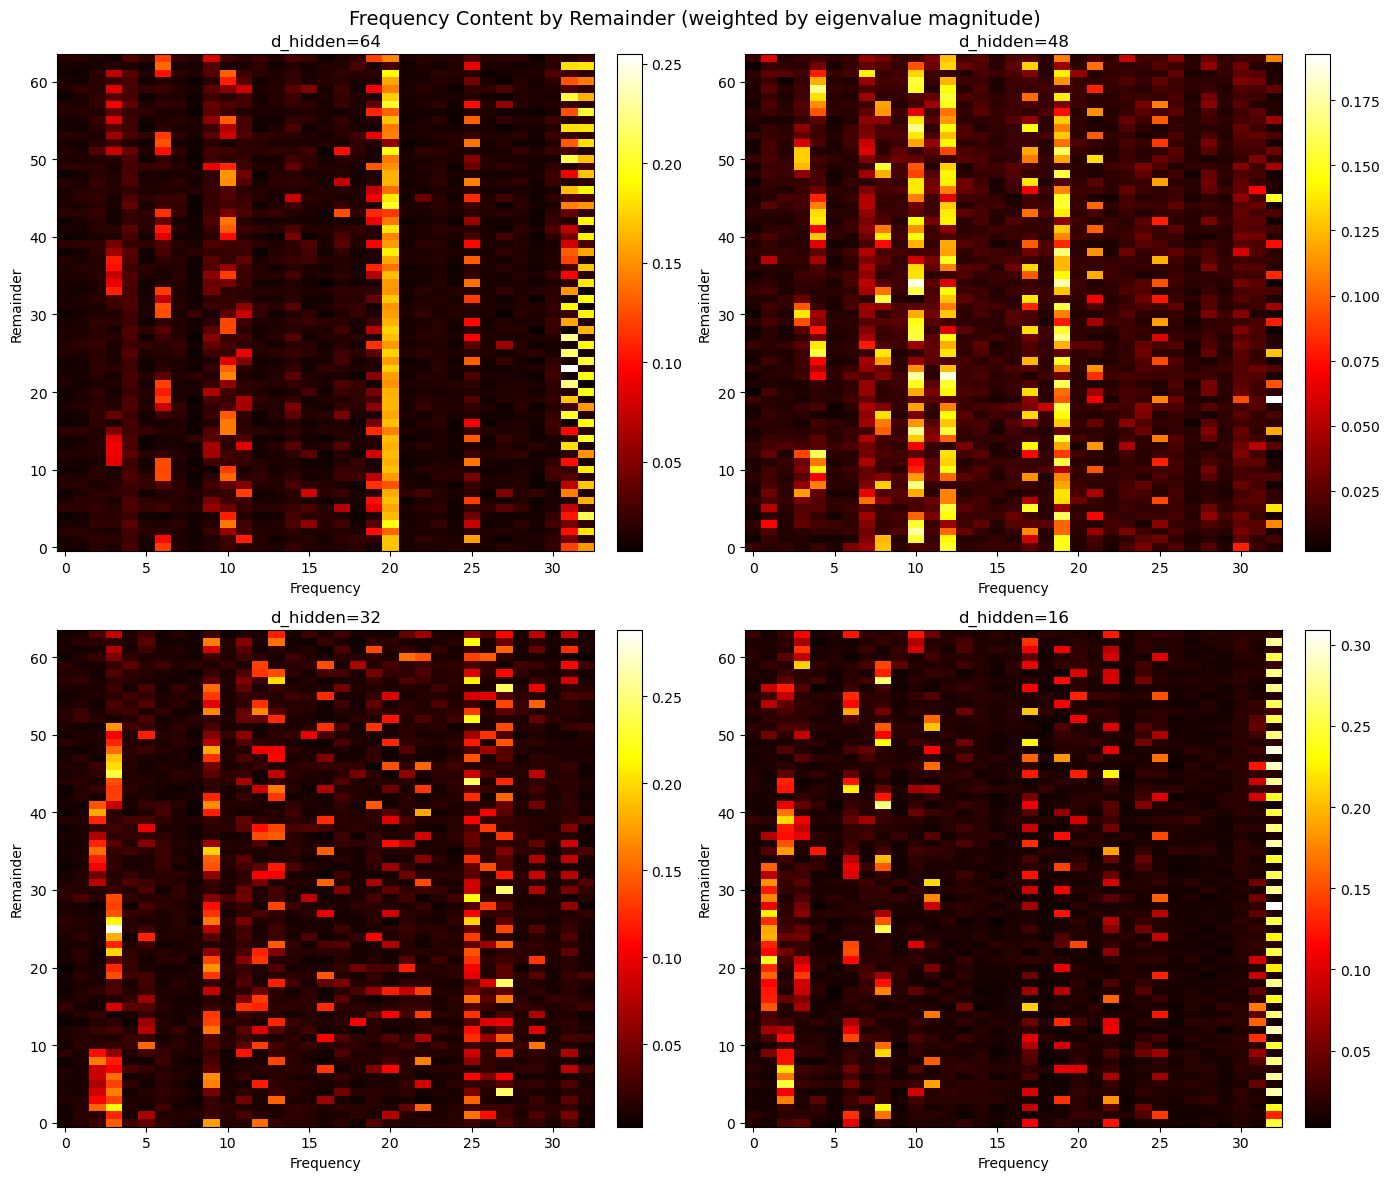

In [20]:
# Create frequency heatmaps (remainder × frequency) for different bottleneck sizes
# For each remainder, sum FFT magnitudes of top eigenvectors

def compute_frequency_heatmap(d_hidden: int, n_evecs: int = 4) -> np.ndarray:
    """
    Compute frequency heatmap for a given bottleneck size.
    Returns (P, P//2+1) array where [r, f] = total FFT magnitude at frequency f for remainder r
    """
    evecs = eigen_data[d_hidden]['eigenvectors']  # (P, 2P, 2P)
    evals = eigen_data[d_hidden]['eigenvalues']   # (P, 2P)
    
    n_freqs = P // 2 + 1
    heatmap = np.zeros((P, n_freqs))
    
    for r in range(P):
        for i in range(min(n_evecs, evecs.shape[2])):
            evec = evecs[r, :, i]
            # Weight by eigenvalue magnitude
            weight = np.abs(evals[r, i])
            
            # FFT of input a component
            fft_a = np.abs(np.fft.rfft(evec[:P]))
            heatmap[r] += weight * fft_a
    
    norm = heatmap.sum(axis=1, keepdims=True)
    return heatmap / norm

# Plot frequency heatmaps for selected bottleneck sizes
bottleneck_sizes_to_plot = [P, P*3//4, P//2, P//4]
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for ax, d_hidden in zip(axes.flat, bottleneck_sizes_to_plot):
    heatmap = compute_frequency_heatmap(d_hidden)
    im = ax.imshow(heatmap, aspect='auto', cmap='hot', origin='lower')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Remainder')
    ax.set_title(f'd_hidden={d_hidden}')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

fig.suptitle('Frequency Content by Remainder (weighted by eigenvalue magnitude)', fontsize=14)
plt.tight_layout()
plt.show()

In [21]:
# Interactive frequency heatmap explorer
def show_freq_heatmap(d_hidden=P, n_evecs=4):
    heatmap = compute_frequency_heatmap(d_hidden, n_evecs)
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(heatmap, aspect='auto', cmap='hot', origin='lower')
    ax.set_xlabel('Frequency', fontsize=12)
    ax.set_ylabel('Remainder', fontsize=12)
    ax.set_title(f'Frequency Heatmap (d_hidden={d_hidden}, top {n_evecs} evecs)', fontsize=14)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

d_slider = widgets.IntSlider(min=1, max=P, step=1, value=P, description='d_hidden')
n_slider = widgets.IntSlider(min=1, max=10, step=1, value=4, description='n_evecs')
out = widgets.interactive_output(show_freq_heatmap, {'d_hidden': d_slider, 'n_evecs': n_slider})
display(widgets.HBox([d_slider, n_slider]), out)

Output()

Compare the frequency distributions:

In [22]:
# TODO: Treat p(f|r) as a distribution per remainder r. Heatmaps are normalized accordingly. 
#       Compute summed JS divergence between these distributions across bottleneck sizes. I.e. distance = sum_{remainder} JS(p_{d1}(f|r) || p_{d2}(f|r))
#       Plot result as heat map as in the TN similarity above.

def JS_divergence(p: np.ndarray, q: np.ndarray) -> float:
    """Compute Jensen-Shannon divergence between two probability distributions."""
    p = p / np.sum(p)
    q = q / np.sum(q)
    m = 0.5 * (p + q)
    def kl_divergence(a, b):
        a = a[a > 0]
        b = b[a > 0]
        return np.sum(a * np.log(a / b))
    return 0.5 * (kl_divergence(p, m) + kl_divergence(q, m))

def compute_frequency_heatmap(d_hidden: int, n_evecs: int = 4) -> np.ndarray:
    """
    Compute frequency heatmap for a given bottleneck size.
    Returns (P, P//2+1) array where [r, f] = total FFT magnitude at frequency f for remainder r
    """
    evecs = eigen_data[d_hidden]['eigenvectors']  # (P, 2P, 2P)
    evals = eigen_data[d_hidden]['eigenvalues']   # (P, 2P)
    
    n_freqs = P // 2 + 1
    heatmap = np.zeros((P, n_freqs))
    
    for r in range(P):
        for i in range(min(n_evecs, evecs.shape[2])):
            evec = evecs[r, :, i]
            # Weight by eigenvalue magnitude
            weight = np.abs(evals[r, i])
            
            # FFT of input a component
            fft_a = np.abs(np.fft.rfft(evec[:P]))
            heatmap[r] += weight * fft_a
    
    norm = heatmap.sum(axis=1, keepdims=True)
    return heatmap / norm

# Compute JS divergence matrix
js_divergence_matrix = np.zeros((P, P), dtype=float)
for i, di in enumerate(range(1, P+1)):
    heatmap_i = compute_frequency_heatmap(di)
    for j, dj in enumerate(range(1, P+1)):
        if j < i:
            js_divergence_matrix[i, j] = js_divergence_matrix[j, i]
        else:
            heatmap_j = compute_frequency_heatmap(dj)
            js_sum = 0.0
            for r in range(P):
                js = JS_divergence(heatmap_i[r], heatmap_j[r])
                js_sum += js
            js_divergence_matrix[i, j] = js_sum



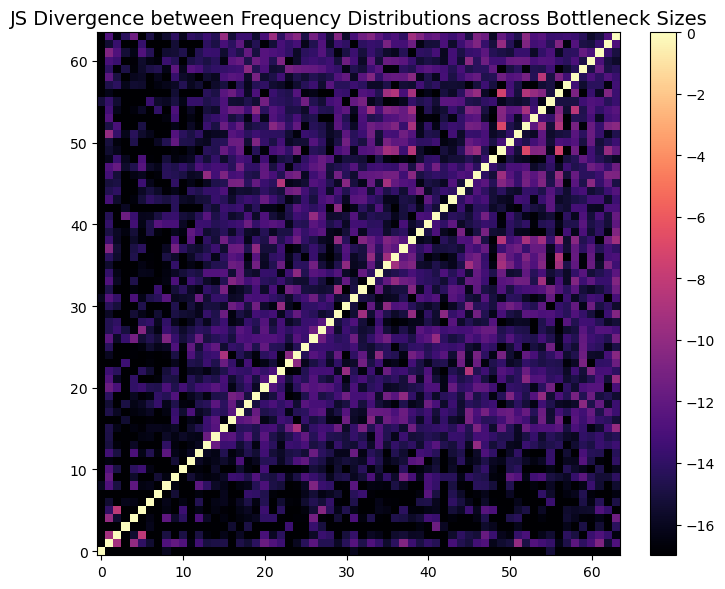

In [23]:
# Plot JS divergence heatmap
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(-js_divergence_matrix, cmap='magma', origin='lower', vmin=-17)
ax.set_title('JS Divergence between Frequency Distributions across Bottleneck Sizes', fontsize=14)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

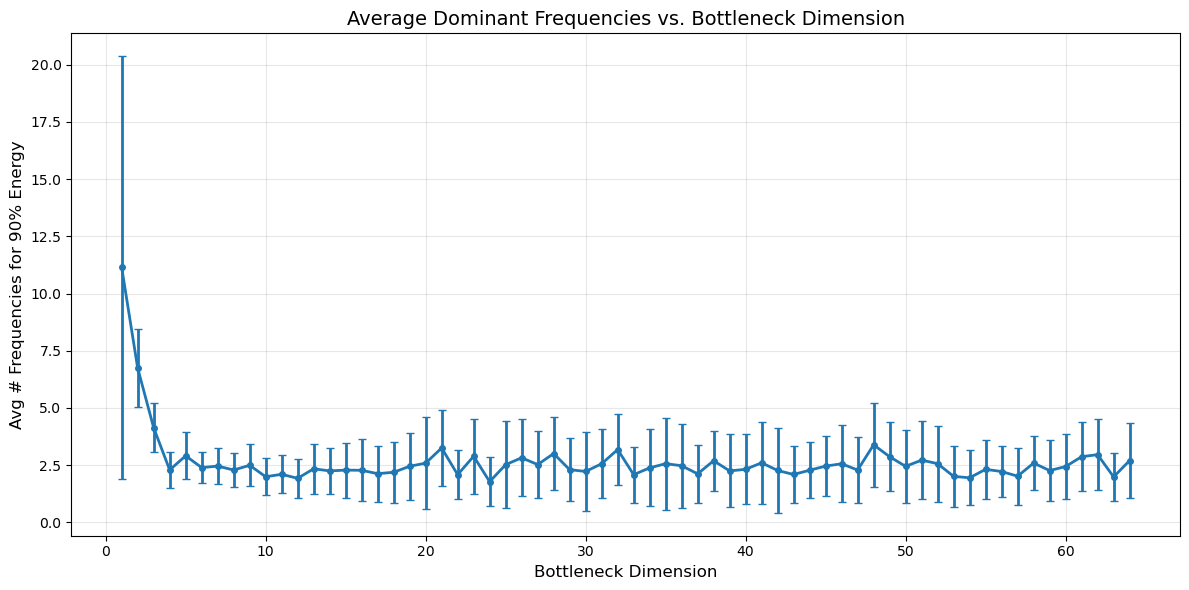

In [24]:
# Analyze number of dominant frequencies needed for reconstruction
# For each eigenvector, count frequencies needed to capture X% of FFT energy

def count_dominant_frequencies(fft_magnitudes: np.ndarray, energy_threshold: float = 0.95) -> int:
    """Count number of frequencies needed to capture energy_threshold of total FFT energy."""
    energy = fft_magnitudes ** 2
    total_energy = energy.sum()
    if total_energy < 1e-12:
        return 0
    
    # Sort by energy (descending)
    sorted_energy = np.sort(energy)[::-1]
    cumulative = np.cumsum(sorted_energy) / total_energy
    
    idx = np.searchsorted(cumulative, energy_threshold)
    return min(idx + 1, len(fft_magnitudes))

# Compute average number of dominant frequencies for each bottleneck size
freq_threshold = 0.90
avg_dominant_freqs = {}

for d_hidden in range(1, P+1):
    evecs = eigen_data[d_hidden]['eigenvectors']
    evals = eigen_data[d_hidden]['eigenvalues']
    
    n_freqs_per_evec = []
    for r in range(P):
        for i in range(min(n_top_evecs, evecs.shape[2])):
            evec = evecs[r, :, i]
            fft_a = np.abs(np.fft.rfft(evec[:P]))
            n_freqs = count_dominant_frequencies(fft_a, freq_threshold)
            n_freqs_per_evec.append(n_freqs)
    
    avg_dominant_freqs[d_hidden] = {
        'mean': np.mean(n_freqs_per_evec),
        'std': np.std(n_freqs_per_evec),
        'median': np.median(n_freqs_per_evec)
    }

# Plot average dominant frequencies vs bottleneck size
dims = list(range(1, P+1))
means = [avg_dominant_freqs[d]['mean'] for d in dims]
stds = [avg_dominant_freqs[d]['std'] for d in dims]

fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(dims, means, yerr=stds, fmt='o-', capsize=3, linewidth=2, markersize=4)
ax.set_xlabel('Bottleneck Dimension', fontsize=12)
ax.set_ylabel(f'Avg # Frequencies for {int(freq_threshold*100)}% Energy', fontsize=12)
ax.set_title('Average Dominant Frequencies vs. Bottleneck Dimension', fontsize=14)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Comment for $P=64$ analysis: For small botllencks, there are more dominant frequencies per eigenvector. However, the frequencies fall of quickly to a value around $5$ frequencies for the FFT-treshhold fixed at $0.95\%$. 